# Comparing model performance with a simple baseline

In this notebook, we present how to compare the generalization performance of
a model to a minimal baseline. In regression, we can use the `DummyRegressor`
class to predict the mean target value observed on the training set without
using the input features.

We now demonstrate how to compute the score of a regression model and then
compare it to such a baseline on the California housing dataset.

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last">If you want a deeper overview regarding this dataset, you can refer to the
section named "Appendix - Datasets description" at the end of this MOOC.</p>
</div>

In [1]:
from sklearn.datasets import fetch_california_housing

data, target = fetch_california_housing(return_X_y=True, as_frame=True)
target *= 100  # rescale the target in k$

Across all evaluations, we will use a `ShuffleSplit` cross-validation splitter
with 20% of the data held on the validation side of the split.

In [2]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=30, test_size=0.2, random_state=0)

We start by running the cross-validation for a simple decision tree regressor.
Here we compute the testing errors in terms of the mean absolute error (MAE)
and then we store them in a pandas series to make it easier to plot the
results.

In [3]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate

regressor = DecisionTreeRegressor()
cv_results_tree_regressor = cross_validate(
    regressor, data, target, cv=cv, scoring="neg_mean_absolute_error", n_jobs=2
)

errors_tree_regressor = pd.Series(
    -cv_results_tree_regressor["test_score"], name="Decision tree regressor"
)
errors_tree_regressor.describe()

count    30.000000
mean     45.753084
std       1.201858
min      43.297206
25%      44.866380
50%      45.834099
75%      46.743583
max      47.965913
Name: Decision tree regressor, dtype: float64

Then, we evaluate our baseline. This baseline is called a dummy regressor.
This dummy regressor will always predict the mean target computed on the
training target variable. Therefore, the dummy regressor does not use any
information from the input features stored in the dataframe named `data`.

In [4]:
from sklearn.dummy import DummyRegressor

dummy = DummyRegressor(strategy="mean")
result_dummy = cross_validate(
    dummy, data, target, cv=cv, scoring="neg_mean_absolute_error", n_jobs=2
)
errors_dummy_regressor = pd.Series(
    -result_dummy["test_score"], name="Dummy regressor"
)
errors_dummy_regressor.describe()

count    30.000000
mean     91.140009
std       0.821140
min      89.757566
25%      90.543652
50%      91.034555
75%      91.979007
max      92.477244
Name: Dummy regressor, dtype: float64

We now plot the cross-validation testing errors for the mean target baseline
and the actual decision tree regressor.

In [5]:
all_errors = pd.concat(
    [errors_tree_regressor, errors_dummy_regressor],
    axis=1,
)
all_errors

,Decision tree regressor,Dummy regressor
0,46.901301,90.713153
1,46.897551,90.539353
2,44.833374,91.941912
3,43.791975,90.213912
4,47.965913,92.015862
5,45.038243,90.542490
6,43.790977,89.757566
7,44.832187,92.477244
8,44.965398,90.947952
9,44.480003,91.991373


/home/karansinghthakor/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


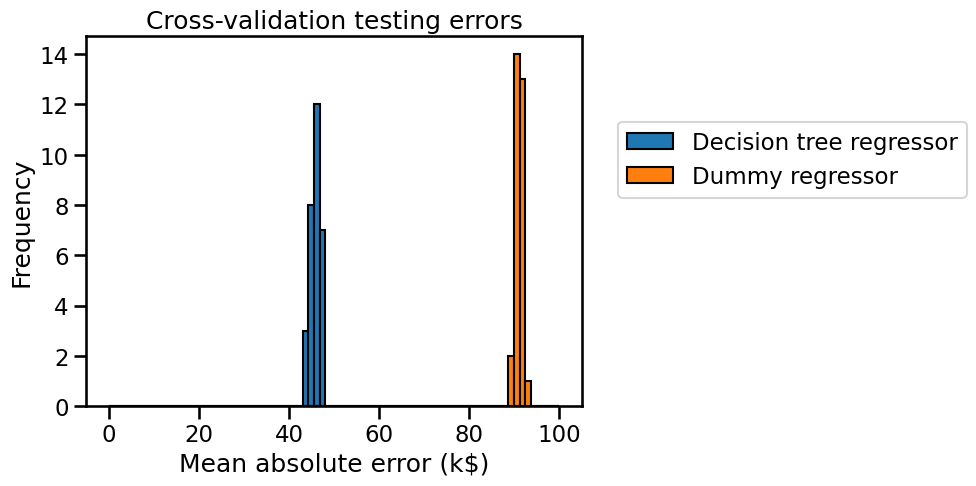

In [6]:
import matplotlib.pyplot as plt
import numpy as np

bins = np.linspace(start=0, stop=100, num=80)
all_errors.plot.hist(bins=bins, edgecolor="black")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.xlabel("Mean absolute error (k$)")
_ = plt.title("Cross-validation testing errors")

We see that the generalization performance of our decision tree is far from
being perfect: the price predictions are off by more than 45,000 US dollars on
average. However it is much better than the mean price baseline. So this
confirms that it is possible to predict the housing price much better by using
a model that takes into account the values of the input features (housing
location, size, neighborhood income...). Such a model makes more informed
predictions and approximately divides the error rate by a factor of 2 compared
to the baseline that ignores the input features.

Note that here we used the mean price as the baseline prediction. We could
have used the median instead. See the online documentation of the
[sklearn.dummy.DummyRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html)
class for other options. For this particular example, using the mean instead
of the median does not make much of a difference but this could have been the
case for dataset with extreme outliers.

Finally, let us see what happens if we measure the test score using $R^2$
instead of the mean absolute error:

In [7]:
result_dummy = cross_validate(
    dummy, data, target, cv=cv, scoring="r2", return_train_score=True, n_jobs=2
)
r2_train_score_dummy_regressor = pd.Series(
    result_dummy["train_score"], name="Dummy regressor train score"
)
r2_train_score_dummy_regressor.describe()

count    30.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: Dummy regressor train score, dtype: float64

The $R^2$ score is always 0. It can be shown that this is always the case,
because of its mathematical definition. If you are interested in the proof,
unfold the dropdown below.

```{admonition} Mathematical explanation
:class: dropdown
Recall that the $R^2$ score is defined as:

$
R^2 = 1 - \frac{\sum_i (y_i - \hat{y}_i)^2}{\sum_i (y_i - \bar{y})^2}
$

But our model always predicts the mean, i.e. for all $i$,
$\hat{y}_i = \bar{y}$, so:

$
R^2 = 1 - \frac{\sum_i (y_i - \hat{y}_i)^2}{\sum_i (y_i - \bar{y})^2}
    = 1 - \frac{\sum_i (y_i - \bar{y}  )^2}{\sum_i (y_i - \bar{y})^2}
    = 1 - 1
    = 0.
$
```

This helps put your model's $R^2$ score in perspective: if your model has an
$R^2$ score higher than 0 then it performs better than a `DummyRegressor` with
`strategy="mean"`; similarly, if the $R^2$ score is lower than 0 then your
model is worse than the dummy regressor. For the test score, we observe
something similar, but with an additional effect coming from the dataset
variations: the mean target value measured on the testing set is slightly
different from the mean target value measured on the training set.

In [8]:
r2_test_score_dummy_regressor = pd.Series(
    result_dummy["test_score"], name="Dummy regressor test score"
)
r2_test_score_dummy_regressor.describe()

count    3.000000e+01
mean    -2.203750e-04
std      3.572610e-04
min     -1.797131e-03
25%     -2.753534e-04
50%     -1.083489e-04
75%     -3.344120e-05
max     -1.015390e-07
Name: Dummy regressor test score, dtype: float64

In conclusion, $R^2$ is a normalized metric, which makes it independent of the
physical unit of the target variable, unlike MAE. A $R^2$ score of 0.0 is the
performance of a model that always predicts the mean observed value of the
target, while 1.0 corresponds to a model that predicts exactly the observed
target variable for each given input observation. Notice that it is only
possible to reach 1.0 if the target variable is a deterministic function of
the available input features. In practice, external factors often introduce
variability in the target that cannot be explained by the available features.
Therefore, the $R^2$ score of an optimal model is typically less than 1.0, not
due to a limitation of the machine learning algorithm itself, but because
the chosen input features are fundamentally not informative enough to
deterministically predict the target.

Overall, $R^2$ represents the proportion of the target's variability explained
by the model, while MAE, which retains the physical units of the target, can
be helpful for reporting errors in those units.